In [1]:
from itertools import chain

import numpy as np
from numpy.polynomial.legendre import Legendre
import pandas as pd
import matplotlib.pyplot as plt
from lmfit.models import ExpressionModel

In [2]:
df = pd.read_excel("Data/Simulated Ne beta parameters, TDCASSCF, 2018-12-18.xlsx", sheet_name="w2w")
df.head()

,target dataset,photon (eV),phi (deg),phi (rad),beta1,beta2,beta3,beta4,beta1m3
0,good1,15.9,0,0.000000,0.041486,-0.325020,0.412740,1.689466,-0.577623
1,good1,15.9,45,0.785398,0.298997,-0.324662,0.617323,1.689486,-0.626988
2,good1,15.9,90,1.570796,0.381801,-0.324688,0.460716,1.689356,-0.309273
3,good1,15.9,135,2.356194,0.241417,-0.325085,0.034634,1.689152,0.189466
4,good1,15.9,180,3.141593,-0.039976,-0.325619,-0.411426,1.688995,0.577163


In [3]:
def _expand(df: pd.Series):
    f = Legendre([1, df["beta1"], df["beta2"], df["beta3"], df["beta4"]])
    x = np.arange(0, 180, 1)
    fx = f(np.cos(x / 180 * np.pi))
    return [
        {
            "Target dataset": df["target dataset"],
            "Photon energy (eV)": df["photon (eV)"],
            "Opt phase (deg)": df["phi (deg)"],
            "Polar ang (deg)": ph,
            "Yield": y,
        }
        for ph, y in zip(x, fx)
    ]


def _fit(d: pd.DataFrame) -> pd.Series:
    model = ExpressionModel('amp * cos(freq * x - shift) + offset')
    model.set_param_hint('amp', value=d["Yield"].std(), min=0)
    model.set_param_hint('freq', value=np.pi/180, vary=False)
    at = d["Yield"].idxmax()
    ph = d["Opt phase (deg)"] * np.pi / 180 % (2 * np.pi)
    model.set_param_hint('shift', value=ph[at], min=-2*np.pi, max=2*np.pi)
    model.set_param_hint('offset', value=d["Yield"].mean())
    result = model.fit(d["Yield"], x=d["Opt phase (deg)"])
    return pd.Series({
        "Model result": result,
        "Photon energy (eV)": d["Photon energy (eV)"].iloc[0]
    })


it = chain.from_iterable(df.apply(_expand, axis=1))
expanded = pd.DataFrame([d for d in it])
fit = (
    expanded
    .groupby(["Target dataset", "Polar ang (deg)"])
    .apply(_fit)
)
fit.head()

Model result  \
Target dataset Polar ang (deg)                                                      
good1          0                <lmfit.model.ModelResult object at 0x7f22aff99...   
               1                <lmfit.model.ModelResult object at 0x7f22af940...   
               2                <lmfit.model.ModelResult object at 0x7f22af940...   
               3                <lmfit.model.ModelResult object at 0x7f22afa5f...   
               4                <lmfit.model.ModelResult object at 0x7f22afa6d...   

                                Photon energy (eV)  
Target dataset Polar ang (deg)                      
good1          0                              15.9  
               1                              15.9  
               2                              15.9  
               3                              15.9  
               4                              15.9

In [4]:
def _params(d: pd.Series) -> pd.Series:
    offset = 1
    return pd.Series({
        "Phase shift (rad)": (d["Model result"].params["shift"].value - offset) % (2 * np.pi) + offset,
        "Photon energy (eV)": d["Photon energy (eV)"]
    }) 


data = fit.apply(_params, axis=1)
data.head()

Phase shift (rad)  Photon energy (eV)
Target dataset Polar ang (deg)                                       
good1          0                         1.076873                15.9
               1                         1.076989                15.9
               2                         1.077336                15.9
               3                         1.077916                15.9
               4                         1.078731                15.9

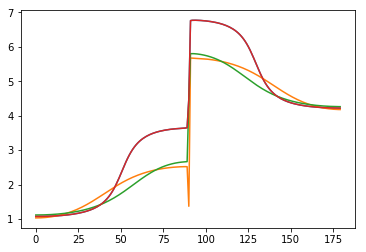

In [5]:
colors = [
    '#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
    '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf',
]

for k, c in zip(["good1", "good2", "good3", "good4"], colors):
#     if k in {"good1"}:
#         continue
    sliced = data.loc[k, :]
    plt.plot(sliced.index, sliced["Phase shift (rad)"], color=c)
plt.show()